# 3. Продажи и регрессия

In [1]:
# Как обычно, для начала подгружаем нужные нам пакеты
import pandas as pd    # пакет для работы с таблицами 
import numpy as np     # пакет для работы с матрицами 

# пакеты для картиночек 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # правильный (наиболее красивый) стиль у графиков

%matplotlib inline

from datetime import datetime # пакет для работы с датами 
# остальные пакеты подгрузим по мере необходимости

## 3.1 Постановка задачи и выбор метрик 

В наших руках оказались [исторические данные по продажам $45$ магазинов Walmart](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting), расположенных в разных регионах. Каждый магазан содержит несколько отделов. Наша задача спрогнозировать продажи по каждому отделу для каждого магазина. Зачем нужно уметь прогнозировать подобные вещи? 

* Если мы привезли в магазин слишком мало товара, потребителем его не хватит. Мало того, что они не принесут нам денег, так ещё и станут к нам менее лояльными: "Не поедем в этот магазин. Там вечно ничего нет." 
* Если мы привезли в магазин слишком много товара, то возникают лишние расходы, связанные с хранением товаров, а также лишние расходы, связанные с просрочкой товаров. 

Хотелось бы уметь избегать всех этих лишних расходов и привозить в каждый магазин ровно столько товара, сколько у нас купят. Ясное дело, что для разных типов товаров мы будем нести разные расходы на хранение, более того разные товары портятся с разной скоростью. В идеале было бы круто предсказывать продажи для каждой отдельной группы товаров. 

Например, для овощей у нас одна модель, для телевизоров вторая, а функции потерь зависят от специфика каждого товара. На практике, скорее всего, так и делают. Мы только учимся и такое разнообразие задач нас угробит. Давайте начнём с чего-нибудь попроще.  В нашем датасете нет детализации. Все продажи измеряются в сумме денег, которую магазин смог заработать в течение недели.

С точки зрения здравого смысла разобрались. Теперь посмотрим на проблему с точки зрения математики. Нужно прогнозировать действительные числа. Перед нами задача регрессии. Качество прогнозов, которые мы делаем нужно оценивать с помощью какой-то метрики. Давайте вспомним какие метрики используются при решении задачи регрессии. 

* MAE (mean absolute error), средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что у нас купять товара на 20 рублей, а на самом деле купили на 10 рублей, мы ошиблись в прогнозах на |10 - 20| = 10 рублей. Средняя абсолютная ошибка - это среднее стоимость, на которую мы облажались. Один из минусов этой ошибки в том, что мы одинаково нелюбим перепрогноз и недопрогноз. В реальности цена этих двух ошибок может быть разной. Решить такую проблему можно немного модернезировав MAE и получив квантильную ошибку.

Например, можно задать кусочную функцию потерь. Если мы завезли на склад слишком мало товара, потребителям не хватит его. Из-за того, что на товар будет наценка, а также из-за его нехватки, мы потеряем лояльность клиентов. Кривая потерь пойдёт под одним углом. Если нехватка будет небольшой, мы покроем её из запасов, потерь не будет. Если на складе будет избыток товара, мы потратим деньги на его хранение, кривая пойдёт под другим углом. Если избыток будет очень сильным, то возникнет просрочка. Кривая пойдёт под третьим углом.

![картинка](nb3_1.png)



* MSE (mean squared error), средняя квадратичная ошибка. Она вычисляется как 

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$

Смысл этой метрики в том, чтобы штрафовать за большие ошибки сильнее, чем за маленькие. Если мы ошиблись на 5 рублей, то в ошибку войдёт 25. Если мы ошиблись на 10 рублей, то в ошибку войдёт 100. Чем выше ошибка, тем сильнее потери. 

При этом эти числа: 25 и 100 это не рубли, а квадратные рули. Каждое слагаемое внутри MSE возводится в квадрат и итоговая сумма получается не очень интерпретируемой. Для борьбы с этим можно взять из MSE квадратный корень. Тогда получится новая ошибка, RMSE. Из-за того, что более большие ошибки для нас страшнее, RMSE обычно получается больше, чем MAE. 

* Часто для нас принципиальным является не то, на сколько денег мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется MAPE (mean absolute percentage error), средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.

* Последняя метрика, с которой нам нужно познакомиться, это коэффициент детерминации, $R^2$. Он отражает то, какую долю дисперсии объясняемой переменной мы объяснили с помощью нашей модели:

$$ R^2 =1- \frac{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y}_i)^2} $$

Эту метрику очень сильно любят консалтеры и аудиторы, потому что только её они и знают. На самом деле в ней нет ничего хорошего. При добавлении в модель новых переменных она всегда растёт. У неё есть ещё несколько тонких математических недостатков, о которых вы можете узнать из книг.

Мы при решении задачи будем использовать MAE и RMSE. Давайте напишим небольшую функцию, с помощью которой нам будем немного удобнее выводить эти две метрики на экран.

In [2]:
from sklearn import metrics  # подгружаем метрики

# функция, которая считает метрики и выводит их на экран
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    pass

# пример:
y_test = [1,2,3,4]
y_pred = [1,1,1,1]
print_metrics(y_test,y_pred)

MAE: 18.479474392471353
RMSE: 27.45431845241556


С тем какую задачу мы решаем и зачем определились. Давайте теперь посмотрим на данные.

## 3.2 Данные? Какие данные? 

**Описание переменных:** 

* `Weekly_Sales` - объём продаж в данную неделю в данном отделе (целевая переменная)
* `Store` - номер магазина;
* `Type` - тип магазина;
* `Size` - размер магазина;
* `Dept` - номер отдела;
* `Date` - дата;
* `IsHoliday` - является ли неделя праздничной;

В Walmart работает несколько акций по уценке товаров. Эти уценки обычно связаны с праздниками: Суперкубок, день Труда, день Благодарения, Рождество. С этими периодами нужно быть аккуратным. Продажи в эти дни аномальны, при этом наблюдений, связанных с этими аномалиями довольно мало.

Для удобства вот информация о всех праздниках, попавших в датасет: 

```
Суперкубок: 12-Фев-10, 11-Фев-11, 10-Фев-12
День Труда: 10-Сен-10, 9-Фев-11, 7-Сен-12
День Благодарения: 26-Ноя-10, 25-Ноя-11, 23-Ноя-12
Рождество: 31-Дек-10, 30-Дек-11, 28-Дек-12
```

* `Temperature` - средняя температура в регионе в градусах по Фаренгейту;
* `Fuel_Price` - стоимость топлива в регионе;
* `MarkDown1-5` - данные, связанные с рекламными уценками, которые запускает Walmart. Данные уценки доступны только после ноября 2011 года и доступны не для всех магазинов. Данные анонимизированы. Непонятно на какие именно товары производилась уценка и в каких количествах. Компании часто анонимизируют данные, когда выкладывают их в опен сорс.  
* `CPI` - индекс потребительских цен.
* `Unemployment` - уровень безработицы.

In [3]:
df = pd.read_csv('walmart.csv', sep='\t')  # подгружаем датасет
print('Размерность таблицы:', df.shape)                  # shape показывает его размер
df.head()                                                # head выдаёт первые 5 строк

Размерность таблицы: (421570, 16)


,Store,Date,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2010-02-05,2,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,2010-02-05,3,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,2010-02-05,4,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,2010-02-05,5,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [4]:
df.info() # посмотрим на то, с какими типами переменных мы имеем дело 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Date            421570 non-null object
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


Для удобства, создадим два списка из переменных. В первый войдут все действительные, во второй все категориальные. Переменная `Weekly_Sales` не войдёт ни в один из списов. Мы же её прогнозируем! Переменная `Date` также не войдёт ни в один из списков. Она техническая и нужна для удобства. Мы на её основе сварим несколько новых переменных немного позже. 

In [5]:
# Date - техническая переменная, 
# Weekly_Sales - таргет

# категориальные переменные 
var_cat = ['Type', 'Store', 'Dept', 'IsHoliday']

# непрерывные переменные
var_real = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5', 'CPI', 'Unemployment', 
            'Temperature', 'Fuel_Price','Size']

In [6]:
# мы в России и мы не понимаем что означает температура в Фарингейтах, переведём их в цельсии
df['Temperature'] = (df['Temperature'] - 32) * 5/9

In [7]:
# посмотрим на основные порядковые статистики, связанные с нашей выборкой
df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,15.605588,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,10.248851,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-18.922222,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,8.155556,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,16.716667,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,23.488889,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,37.855556,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


Заметили аномалии? Нет? Присмотритесь к колонке `Weekly_Sales`. Минимальное значение отрицательное. Как думаете, что это значит? Давайте оценим масштаб бедствия. 

In [8]:
sum(df['Weekly_Sales'] < 0)/df.shape[0]

0.0030481296107408022

Таких точек совсем мало. Что же означают отрицательные продажи? Один из способов проинтерпретировать это: нам вернули назад товаров больше, чем мы смогли продать. В маленьких магазинах такое вполне могло произойти. Другая интерпретация: ошибка при создании датасета. Как поступать с такими наблюдениями непонятно. Давайте пока что оставим их. 

Построим несколько картинок, чтобы немного лучше прочувствоват выборку. Посмотрим на то, какое распределение у целевой переменной. 

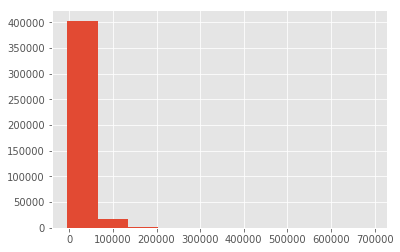

In [9]:
df.Weekly_Sales.hist( )

У распределения цен есть проблема - очень длинный хвост. В выборке встречаются точки с доаольно большими суммами продаж. Такие наблюдения называются выбросами. С ними нужно бороться, иначе модель подстроится под них. Давайте сгладим распределение цен, прологарифмировав его. Так довольно часто поступают с целевой переменной. Мы ниже попробуем обучить модель на оба таргета.

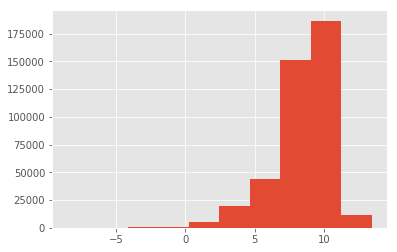

In [10]:
df['ln_Weekly_Sales'] = df['Weekly_Sales'].apply(lambda w: np.log(w) if w > 0 else -np.log(-1*w + 1))
df.ln_Weekly_Sales.hist( )

Посмотрим на матрицу корреляций. Возможно мы увидем на ней какие-то интересные закономерности. 

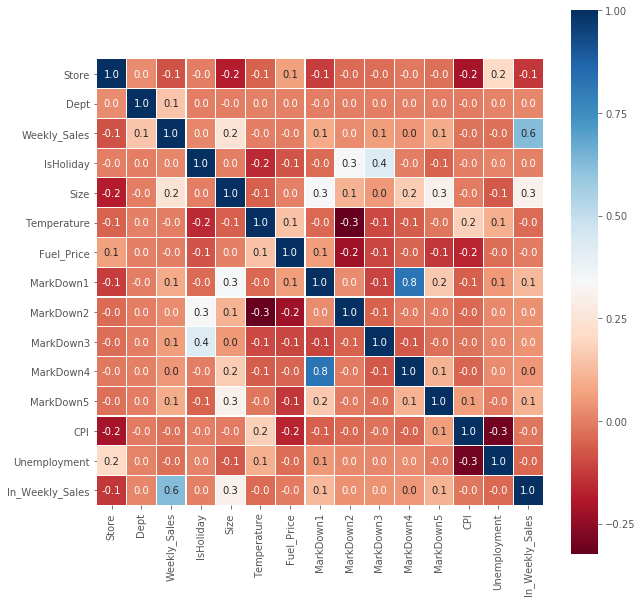

In [11]:
plt.figure(figsize=(10,10))
corr = df.corr()  # посчитали корреляции между регрессорами

# рисуем корреляционную матрицу
sns.heatmap(corr, annot=True, square=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Видим закономерности: 

* Скидки коррелируют между собой
* Более высокий уровень безработицы означает более низкий ИПЦ (это кстати говоря в экономике называется кривой Филиппса, подробнее об этом можно узнать в бонусных материалах в конце тетрадки) 
* Более высокие номера отделов имеют более высокие продажи. Возможно, это связано с тем, что они новее. 
* Большие магазины генерируют больше продаж.
* Скидки стимулируют продажи.
* Большая безработица приводит в меньшим продажам. 
* Между температурой, праздниками и стоимостью топлива в регионе и продажами почти никакой линейной связи нет. 

Посмотрим на то как распределены наши признаки. Иногда это помогает избежать проблем. 

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

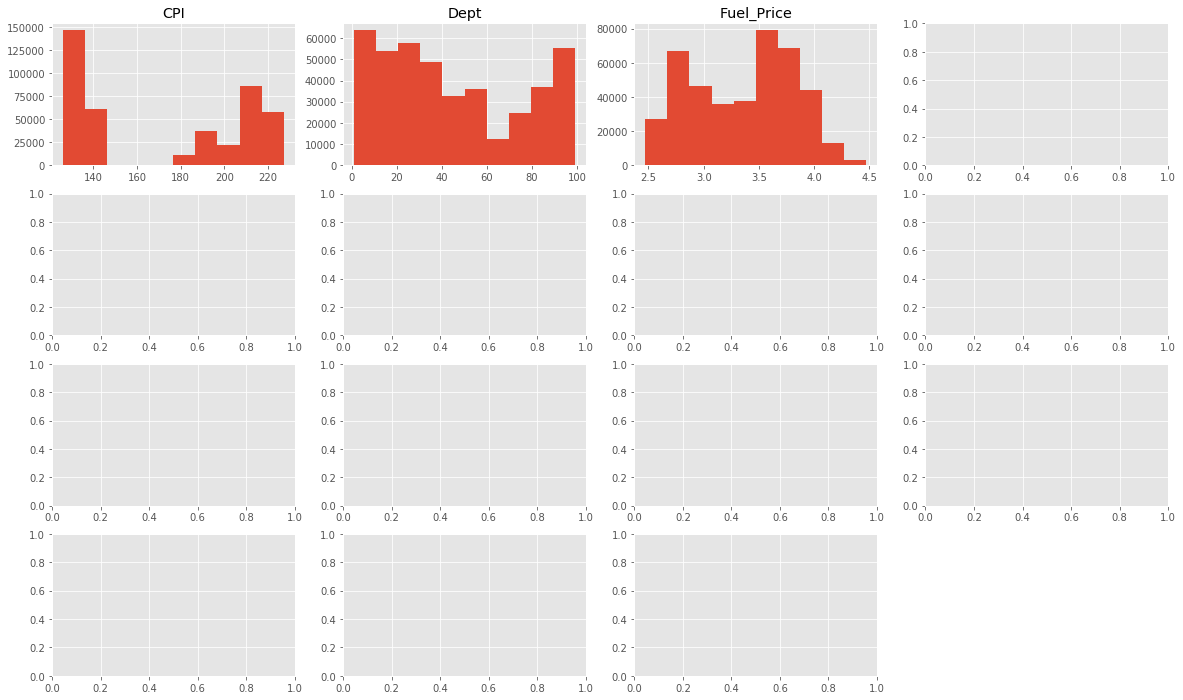

In [12]:
df.hist(figsize=(20, 12))

Мы видим, что наблюдения среди всех магазинов распределены равномерно. У нас в выборке есть наблюдения для магазинов разных размеров. Если бы в выборке в этих параметрах был перекос, было бы плохо. Скидки тоже имеют распределения с длиными хвостами. Возможно, имеет смысл прологорифмировать их. 

Построим ешё облака рассеивания. На них можно заметить, что стоимость топлива зависит от температуры на улице. Также можно увидеть, что целевая переменная квадратично зависит от многих факторов. Если мы захотим остановиться на линейной модели, надо попробовать добавить в неё квадраты этих факторов. Но об этом позже. 

In [ ]:
sns.pairplot(df[var_real + ['ln_Weekly_Sales']].dropna())

Последняя картинка перед обработкой данных. Посмотрим на динамику цен в течение приведённых в выборке трёх лет. 

In [ ]:
# картинка с временем года, когда цены самые большие 
df.groupby('Date')['Weekly_Sales'].mean().plot(figsize=(15,5))

Наблюдается сезонность в покупочках. Есть два пика. Один приходится на день благодарения, второй на рождество. Нужно ввсти какаие-то переменные, которые будут это улавливать.

## 3.3 Предобработка данных

Мы немного посмотрели на картинки, построенные по нашим данным. Этот анализ дал нам несколько идей, связанных с тем какие фичи можно сварить для нашей модели. Пойдём по следущему сценарию: 

* Смотрим на пропуски и боримся с ними
* Варим крутые переменные (устроить брэйншторм)
* Смотрим на категориальные переменные и предобрабатываем их
* Разбиваем выборку на тренировочную и тестовую
* Скалируем действительные переменные

Посмотрим на пропуски. На картинке ниже жёлтая клетка - это пропуск. Лиловая - это наблюдение. 

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Видим, что переменные, связанные сос кидками довольно пустые. Это может быть связано с двумя причинами: скидок не было либо данные забыли внести. Логично заполнить все пропуски нулями. 

In [ ]:
df.fillna(0, inplace=True)  # опция inplace применяет изменения к df

Приступаем к варке фичей. Какие есть идеи по этому поводу? 

* Чёрная пятница и предрождественские праздники (аномальные покупки)
* Переменная, отвечающая за текущий месяц (сезонность)
* Квадраты некоторых переменных (не будем делать, это ваше задание) 

Что ещё? 


In [ ]:
# Внимание! Сложности! В этой ячейке мы работаем со временем. Тут много незнакомых для вас команд. 
# Постарайтесь разобраться в них самостоятельно, если не получится пишите. 
# Работа со временем для чайников: https://pythonworld.ru/moduli/modul-datetime.html

# делаем у колонки дата временной тип
df['DateType'] = df['Date'].apply(lambda w: datetime.strptime(w, '%Y-%m-%d')) 

# вводим отдельную переменную для месяца, когда происходили продажи 
df['Month'] = df['DateType'].apply(lambda w: 'Month_' + str(w.month))

# Работаем с особыми днями! 
# Чёрная пятница
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | \
                              (df['DateType']==datetime(2011, 11, 25).date()) | \
                              (df['DateType']==datetime(2012, 11, 23).date()), 1, 0)

# Предрождественские деньки: 
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | \
                               (df['DateType']==datetime(2010, 12, 24).date()) | \
                               (df['DateType']==datetime(2011, 12, 23).date()) | \
                               (df['DateType']==datetime(2011, 12, 24).date()) | \
                               (df['DateType']==datetime(2012, 12, 23).date()) | \
                               (df['DateType']==datetime(2012, 12, 24).date()), 1, 0)


Удалим все технические переменные. В нашем случае это дата. 

In [ ]:
df.drop(['DateType', 'Date'], axis=1, inplace=True)

In [ ]:
df.head( )

Займёмся предобработкой категориальных переменных. Как вы помните из предыдущего блокнота про титаник, это делается одним горячим кодированием (One Hot Encoding).

In [13]:
df['Store'] = df['Store'].astype('str')  # каждое число - категория, сообщим питону об этом
df['Dept'] = df['Dept'].astype('str')    # каждое число - категория, сообщим питону об этом

print('Размерность таблицы до OHE:', df.shape)
df = pd.get_dummies(df)
print('Размерность таблицы после OHE:', df.shape)
df.head()

Размерность таблицы до OHE: (421570, 17)
Размерность таблицы после OHE: (421570, 285)


,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
0,24924.50,False,151315,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,50605.27,False,151315,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2,13740.12,False,151315,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,39954.04,False,151315,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
4,32229.38,False,151315,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0


Разделим выборку на две части: тренировочную и тестовую.

In [14]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 70 к 30
df_train, df_test = train_test_split(df, test_size = 0.3) 

Только что мы согрешили. Данные, которые есть у нас в распоряжении имеют структуру временного ряда. То есть то, сколько я купил сегодня, скорее всего зависит от того, сколько я купил вчера. Между соседними наблюдениями есть взаимосвязь. Мы, когда дробим выборку на тренировочную и тестовую, рвём эту взаимосвязь и пренебрегаем ей. 

Часто временная структура данных помогает извлечь дополнительные закономерности. Например, в нашей ситуации мы могли бы для каждого магазина добавить ещё одну объясняющую переменную: вчерашние продажи. Это позволило бы улучшить качество модели. Мы для простоты не будем делать этого.  

Последний предобрабатывательский штрих это скалирование (стандартизация непрерывных переменных).

In [15]:
from sklearn.preprocessing import StandardScaler  # класс для скалирования

# объявили скалировщик!
scaler = StandardScaler()

# учим скалировщик скалировать все переменны на трэйне
scaler.fit(df_train[var_real]) 

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
# Применяем скалировщик к трэйну
df_train_scale = scaler.transform(df_train[var_real])

# Применяем скалирвощик к тесту 
df_test_scale = scaler.transform(df_test[var_real])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [17]:
# Заменяем значения на проскалированные 
df_train[var_real] = df_train_scale
df_test[var_real] = df_test_scale

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

In [18]:
df_train.head()

,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
174124,38150.47,True,-0.263837,-1.501801,0.087998,-0.486366,5.359863,-0.118437,-0.439362,-0.560440,...,0,0,0,0,0,0,0,0,1,0
162061,2293.95,False,-0.714298,-0.441047,0.960916,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
216161,581.75,False,-0.281813,0.561168,1.118041,0.390654,-0.344283,-0.138869,0.527278,0.002623,...,0,0,0,0,0,0,0,0,1,0
421360,485.38,False,-0.303725,0.261425,1.360276,-0.264443,NaN,-0.147736,-0.177980,-0.382792,...,0,0,0,0,0,0,0,0,1,0
239757,11576.68,False,-0.141583,-0.235617,-0.961686,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0


In [19]:
# для удобства запишем в y то, что мы хотим спрогнозировать, а в X то, по чему мы это будем делать.
y_train = df_train['ln_Weekly_Sales']
y_test = df_test['ln_Weekly_Sales']

X_train = df_train.drop(['Weekly_Sales','ln_Weekly_Sales'], axis=1).get_values()
X_test = df_test.drop(['Weekly_Sales','ln_Weekly_Sales'], axis=1).get_values()

## 3.4 Моделирование

### 3.4.1 Наивный прогноз 

Шаг первый. Построим константный прогноз. Будем говорить, что продажи в любом магазине совпадают со средним значением. Это самый глупый прогноз, который мы можем сделать. С ним мы будем сравнивать прогнозы более сложных моделей. 

In [20]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им продажи
y_pred_naive[:5]

array([8.48291046, 8.48291046, 8.48291046, 8.48291046, 8.48291046])

In [21]:
# та самая функция, которую мы сделали в самом начале тетрадки
print_metrics(y_test, y_pred_naive)

MAE: 13710.457463911798
RMSE: 25378.14441158619


### 3.4.2  Линейная регрессия

Пришло время построить линейную регрессию! Эта модель говорит, что объём продаж формируется в результате суммирования тех характеристик, которыми обладает магазин с какими-то весами

$$\hat{y} = \beta_0 + \beta_1 x_1 + ... \beta_n x_n.$$

Например, если мы оценили модель и у нас получилось, что 

$$ sales = 10000 + 20 \cdot t,$$

то это означает, что средний объём продаж равен 10 тыс. рублей. При этом каждый дополнительный градус температуры на улице в среднем при прочих равных увеличивает объёмы продаж на 20 рублей. 

Для того, чтобы подобрать коэффициенты обычно минимизируют MSE. Мы с вами делали это руками на семинаре. Пришло время проделать это на комплюхтере. Заставим вкалывать этот кусок железа.

In [22]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Посмотрим на ошибку прогноза на тестовой выборке. По сравнению с наивным прогнозом, она довольно сильно упала. Ура! Наша модель не бесполезна!

In [ ]:
print_metrics(y_test,y_pred_regr)

В следущих двух ячейках код для визуализации результатов. Да, на первый взгляд он страшный. Если освоитесь с питоном как следует, он перестанет быть страшным. Пока можете проигнорировать его. 

In [ ]:
def visualize_coefficients(model, feature_names, n_top_features=10):
    """
        Рисует картинку с важностью фичей 
            model - модель
            feature_names - названия переменных
            n_top_features - сколько самых важных переменных надо нарисовать
    """

    coef = model.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + 2 * n_top_features), 
                feature_names[interesting_coefficients], rotation=75, ha="right");
    pass


def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=0.1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('Quality', fontsize=14)
    plt.ylabel('Estimated quality', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=0.1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('Quality', fontsize=14)
    plt.ylabel('Estimated quality', fontsize=14)
    pass

Давайте посмотрим, какие переменные оказывают самое сильное влияние на продажи. 

In [ ]:
visualize_coefficients(model_regression, df_train.drop('Weekly_Sales', axis=1).columns, 30)

В результатах нет ничего неожиданного. Продажи сильно зависят от времени года и конкретного магазина. Попробуем добавить в модель немного регуляризации. 

Теперь давайте визуализируем прогнозы. По оси $x$ отложены рельные значения продаж, по оси $y$ отложены прогнозы. Если модель работает хорошо, прогноз должен совпадать с реальным значением и наши точки на обоих картинках должны выстроиться вдоль диагонали. Мы видим, что такого не происходит. Тем не менее можно постараться вытянуть облако ещё сильнее и улучшить прогнозы. 

In [ ]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model_regression)

### 3.4.3 Lasso-регрессия 

Оценим Lasso-регрессию. Напомню, что её основная фишка в том, что она зануляет коэффициенты перед несущественными переменными. Вместо MSE минимизируется функционал 

$$MSE + \alpha \cdot \sum |\beta|.$$ 

Это позволяет дать бой переобучению отобрать самые важные фичи. Гиперпараметр $\alpha$ приходится подбирать отдельно. Попробуем сначала обучить дефолтную модель. В ней $\alpha = 1$. 

In [38]:
from sklearn.linear_model import Lasso  # подгрузили модель

# Объявили модель
model_simplelasso = Lasso()

# Обучили модель на тренировочной выборке 
model_simplelasso.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_lasso = model_simplelasso.predict(X_test)

In [39]:
print_metrics(y_test,y_pred_lasso)

MAE: 13650.266868177501
RMSE: 25246.95954250788


Качество модели рухнуло. Попробуем подобрать оптимальное значение для нашего параметра. 

In [40]:
%%time
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.001}
CPU times: user 8min 26s, sys: 54.9 s, total: 9min 21s
Wall time: 8min 45s


In [41]:
print_metrics(y_test,y_pred_lasso)

MAE: 6853.02780135924
RMSE: 13963.923553138506


Видим, что в данном случае гиперпараметр хочет обратиться в ноль. На этом остановимся в модернизации регрессии. С регуляризацией вам предстоит немного поиграться в домашнем задании. Давайте посмотрим напоследок ещё одну модель. 

### 3.4.4  Случайный лес

Попробуем более сложную модель, случайный лес. В ходе его обучения будут строится деревья. Каждое из них будет выдавать прогноз, потом мы будем по всему лесу прогнозы усреднять. В итоге будет получаться нечто прекрасное. 

In [42]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Объявили лес из 10 деревьев 
rf = RandomForestRegressor(n_estimators=10)

# Обучили лес 
rf.fit(X_train, y_train)

# Сделали по лесу прогнозы 
y_pred_forest = rf.predict(X_test)

CPU times: user 1min 52s, sys: 954 ms, total: 1min 53s
Wall time: 1min 53s


In [43]:
print_metrics(y_test,y_pred_forest)

MAE: 1619.3500578003138
RMSE: 4179.968354675747


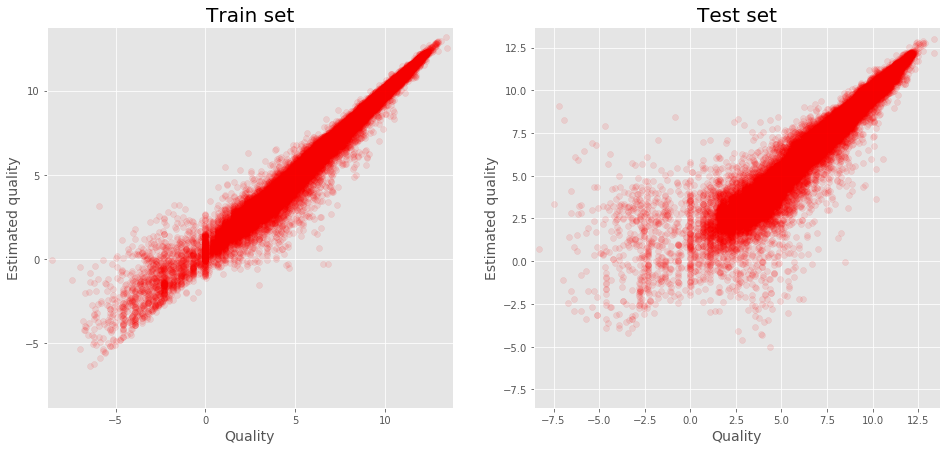

In [44]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, rf)

Качество прогнозов довольно сильно возрасло, на нашей визуализации точки намного сильнее вытянулись вдоль диагонали. 

## 4. Сравниваем модели между собой 

In [45]:
print_metrics(y_test,y_pred_naive)

MAE: 13650.266868177501
RMSE: 25246.95954250788


In [46]:
print_metrics(y_test,y_pred_regr)

MAE: 7073.552709593158
RMSE: 14539.82093256853


In [47]:
print_metrics(y_test,y_pred_lasso)

MAE: 6853.02780135924
RMSE: 13963.923553138506


In [48]:
print_metrics(y_test,y_pred_forest)

MAE: 1619.3500578003138
RMSE: 4179.968354675747


Так какую же модель выбрать? Если нас интересуют хорошие прогнозы, то в данный момент лидирует случайный лес. Минус леса состоит в том, что он неинтерпретируемый. Если нас это волнует, придётся ещё поработать над линейной моделью. Именно это предлагается вам прямо сейчас сделать в задании. Оно лёгкое, не стесняйтесь выполнить его. 

## Задание: 

1. Когда мы оценивали модель, мы проскалировали все действительные переменные. Попробуйте не скалировать их. Как изменилось качество моделей? Почему?
2. Прологарифмируйте все скидки (переменные markdown), добавьте в регрессию квадраты для температуры, цены на топливо. Как изменилось итоговое качество моделей? Почему? 
3. В самом начале мы говорили о кусочной метрике дле оценки качества моделей. Реализуйте её и сравните по ней модели между собой. Сколько денег мы потеряем в течение тестового периода, если будем использовать наивный прогноз? Сколько денег мы потеряем, если будем использовать самую крутую из полученных моделей? 

In [ ]:
# Внимание! Для 1 и 2 пунктов надо менять содержимое тетрадки
# Тут нужно писать только код для новой метрики.

# ваш код для метрики 

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Бонус

Помните, когда мы смотрели на корреляционную матрицу, мы увидели, что между безработицей и инфляцией есть отрицательная взаимосвязь: чем больше безработица, тем ниже инфляция. В экономике эта взаимосвязь называется кривой Филиппса. И за ней кроется очень интересная история из целой плеяды ошибок. Давайте попробуем научиться на чужих ошибках чему-нибудь новому. 

В $1958$ году была опубликована статья экономиста Филиппса, в которой он обнаружил достаточно чёткую отрицательную связь между инфляцией и безработицей в Англии за прошедшие $70$ лет. Проверка этой работы на американских данных подтвердила наличие взаимосвязи. Так родилась знаменитая кривая Филиппса. Её стали интерпретировать как некую возможность выбора между высокой инфляцией и высокой безработицей. Нужно сократить безработицу? Давайте напечатаем денег и разгоним инфляцию!

Любому политику безработица кажется более значимой социальной проблемой, нежели инфляция, и он хочет её победить любыми доступными средствами. Самым популярным средством по борьбе с безработицей является агрессивная монетарная политика, которая состоит в расширении денежной массы. Грубо говоря, просто печатают ещё денег. Именно это и было сделано президентом США Ричардом Никсоном в начале $1970$-х гг. в ходе погони за низкой безработицей и высокой инфляцией.

К сожалению, план Никсона удался только наполовину, он добился высокой инфляции, но сбить безработицу не смог. В краткосрочном периоде она действительно упала, но через некоторое время вернулась назад. Кривая Филиппса в этот период времени исчезла из данных. Никой взаимосвязи между безработицей и инфляцией больше не прослеживалось.

В течение $70$-х все Западные страны поэкспериментировали с кривой Филиппса. В конечном итоге, $1980$-е годы были потрачены на обуздание разогнанной инфляции. Победа над инфляцией обошлась довольно дорого. Например, Пол Волкер, возглавлявший в этот период времени ФРС США, взвинтил процентную ставку до $19\%$. Высокие ставки отправили экономику в рецессию. Такая жёсткая принципиальная политика ФРС позволила сбить инфляционные ожидания.

Какова мораль этой истории? Политики увидели в данных закономерность, но начав бороться с безработицей, печатая деньги, немного перепутали причину и следствие. На самом деле никакой чёткой отрицательной зависимости между инфляцией и безработицей в природе не существует. Её наличие в данных является следствием сложного взаимодействия между экономическими агентами. Попытавшись воздействовать на следствие, а не на причину, политики налажали.

Не путайте причину и следствие, когда смотрите в данные и помните, что работа с ними малость сложнее, чем просто открыть питон и оценить пару деревьев.